# Propagation of a Cloud of Pollutant in River

## Introduction

The objective of this workshop is to obtain insight into the time integration and space discretization of the **advection equation**.
In this respect, **accuracy** and **stability** play a major role.

As background to this assignment, it is necessary to have some knowledge on the numerical solution to the advection equation. Please read chapter *Numerical methods of PDEs* of the MUDE book beforehand.

We consider a cloud of pollutant that is propagating in the river. With this exercise we want to explore the numerical properties of spatial discretization to be applied, in particular **central differences** and the first order **upwind scheme**.
In addition and related to this, we explore stability properties of the **forward Euler scheme**.

Specifically, we will carry out the following tasks:
- implement central differences and the first order upwind scheme combined with forward Euler - Python programming
- evaluate accuracy and stability by varying the time step and grid size - making plots and writing down the results

With respect to programming requirements, you will need to fill in a few missing pieces of the functions, but mostly you will adapt the values of a few Python variables to evaluate different aspects of the problem.

## Specifications of the test case

The assignment involves a river section of 60 km in which one finds a given cloud of pollutant at $t=0$. Initially, the cloud of pollutant has either a block-shaped profile or a Gaussian bell curve with a maximum concentration of $c^0 = 1$ kg/m$^3$. The maximum width of the cloud is 4 km. The initial cloud is located *within* the river section such that it does not hit the left boundary of the domain, that is, at $x=0$ the concentration of the pollutant is zero, $c(0,t) = 0$. This cloud is propagating through the river with a flow speed of 0.5 m/s until it reach almost the right boundary of the domain, that is, the tail of the cloud does not hit that boundary. So, the concentration must remain zero all times at $x = 60$ km.

## Part 1: implementation of spatial discretizations

Our first task is to complete the code below by implementing both central differences and the first order upwind scheme. In order to do this, we first carry out a pen-and-paper exercise. 

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1</b>

1. Write down the advection equation for the above problem. Indicate the type of this PDE.
2. Specify the initial condition. Write down the formulas for both block- and bell-shaped profiles in full.
3. Determine the duration of the simulation. This duration should be chosen such that the cloud has not left the domain by the last time step.

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>
<b>Solution 1.1</b>

1. The advection equation reads

   $$
     \frac{\partial c}{\partial t} + u\,\frac{\partial c}{\partial x} = 0
   $$

   This PDE is of the **hyperbolic** type.
2. There are two different profiles given for the initial condition:
   - the block-shape profile is given by

     $$
      c(x,0) =
         \begin{cases} 0\, , \quad x < x_f \\
                       \\
                       c^0\, , \quad x_f \leq x \leq x_f+4000 \\
                       \\
                       0\, , \quad x_f+4000 < x
         \end{cases}
     $$

     with $x_f$ the location of the front of the block. The block profile must be within the domain, therefore $x_f > 0$.
     We choose $x_f=2000$ so that the center of gravity of the block profile is at $x = 4000$.
   - the bell curve is given by the following Gaussian function

     $$
       c(x,0) = c^0 \exp(-\frac{(x-\mu)^2}{2\sigma^2})
     $$

     where $\mu$ represents the position of the peak of the bell curve and $\sigma$ is the standard deviation that controls the width of the bell.
     Since the bell width is approximately six times the standard deviation, we have $\sigma = 4000/6 = 666.66666...$.
     We choose the peak center at $\mu = 4000$ so that the bell curve is within the domain and does not hit the left boundary of the domain.

3. The center of gravity of the initial condition described by both profiles is at $x = 4000$.
   To prevent hitting the right boundary at $x=60000$, we let this center travel
   until $x = 60000-4000 = 56000$. Hence the distance travelled equals $56000 - 4000 = 52000$ m.
   Since the flow speed is 0.5 m/s, the end time is then given by $t_{\text{end}} = 52000/0.5 = 104000$ s, so that the simulation time is almost 29 hours.

</p>
</div>

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2</b>

The discretization of the advection equation is based on the MOL approach. Explain in your own words what this method involves.

We study two schemes for solving the advection equation, namely, the FTCS scheme and the FTBS scheme. Write down these schemes.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>
<b>Solution 1.2</b>

The Method of Lines is a method to solve the PDE numerically. First, the spatial discretization is carried out so that the PDE is converted into a system of ODEs. Then this system is integrated over time which results into an algebraic system of equations. There is no need to solve this system of equations as long as the time integration is explicit. In that case, an update in the numerical solution is made in each inner grid point.

The FTCS scheme applied to the advection equation reads

$$
 \frac{c^{n+1}_m-c^n_m}{\Delta t} + u \frac{c^n_{m+1}-c^n_{m-1}}{2\Delta x} = 0
$$

where $\Delta t$ is the time step, $\Delta x$ is the mesh size and $c^n_m$ is the numerical solution at point $x_m$ and time $t_n$.
Since this scheme is explicit, we can express the the solution at new time step $t_{n+1}$ in terms of the solution at present time step $t_n$,
namely,

$$
 c^{n+1}_m = c^n_m - u \,\Delta t \, \frac{c^n_{m+1}-c^n_{m-1}}{2\Delta x}
$$

Thus, the code implementation looks like this

```
  c_new[i] = c[i] - 0.5 * dt * u * (c[i+1] - c[i-1]) / dx
```
<br>
The FTBS scheme is an upwind-type scheme where the flow direction plays a role. In our case, $u>0$ and therefore our FTBS scheme is given by

$$
 \frac{c^{n+1}_m-c^n_m}{\Delta t} + u \frac{c^n_{m}-c^n_{m-1}}{\Delta x} = 0
$$

Here we have applied the first order backward difference scheme.
</p>
</div>

We will now implement both schemes in the code below. The idea is that we will loop over each of the inner grid points in the computational domain, one at a time. So we are not going to set up a system of equations in a matrix form.

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from ipywidgets import interact, fixed, widgets

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.3</b>

Use your schemes derived in <b>Task 1.2</b> to complete the function <code>advection_1D</code> in the code cell below.

</p>
</div>

Note that other functions are complete. These functions initialize the problem, check your problem and also plot your results.

In [2]:
def initialize_1D(c0, L, Nx, T, Nt, square=True):
    
    dx = L/Nx
    dt = T/Nt
    
    x = np.linspace(0, L, Nx)

    # initialise cloud:
    #  - a square pulse or a Gaussian shape pulse
    if square:
        c_init = np.zeros(Nx)
        c_init[int(2000/dx):int(2000/dx)+int(4000/dx) + 1] = c0
    else:
        s = 4000/6
        c_init = np.exp(-((x-4000)**2)/(2*s*s) )

    c_all = np.zeros((Nt+1, Nx))
    c_all[0] = c_init
    return x, c_all, dx, dt

def advection_1D(c, dx, dt, u, Nx, central=True):

    c_new = np.zeros(Nx)
    for i in range(1, Nx-1):
        if central:
            # central difference scheme
            c_new[i] = c[i] - 0.5*u*dt * (c[i+1] - c[i-1])/dx
        else:
            # first order upwind scheme
            c_new[i] = c[i] - u*dt * (c[i] - c[i-1])/dx
    return c_new
    
def run_simulation_1D(c0, u, L, Nx, T, Nt, central=True, square=True):
    
    x, c_all, dx, dt = initialize_1D(c0, L, Nx, T, Nt, square=square)
    
    for t in range(Nt):
        c = advection_1D(c_all[t], dx, dt, u, Nx, central=central)
        c_all[t + 1] = c
        
    return x, c_all
    
def plot_1D(x, c, step=0):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, round(x.max())),
                  ylim=(-0.5, int(np.ceil(c[0].max())) + 0.5))  
    ax.plot(x, c[step], marker='.')
    plt.xlabel('$x$ [m]')
    plt.ylabel('concentration [kg/m$^3$]')
    plt.title('propagation in river')
    plt.show()
    
def plot_1D_all():
    play = widgets.Play(min=0, max=Nt-1, step=1, value=0,
                        interval=100, disabled=False)
    slider = widgets.IntSlider(min=0, max=Nt-1, step=1, value=0)
    widgets.jslink((play, 'value'), (slider, 'value'))
    
    interact(plot_1D, x=fixed(x), c=fixed(c_all), step=play)

    return widgets.HBox([slider])
    
def check_variables_1D():
    dx = L/Nx
    dt = T/Nt
    print('Current variables values:')
    print(f'  c0 [---]: {c0:0.2f}')
    print(f'  u  [m/s]: {u:0.2f}')
    print(f'  L  [ m ]: {L:0.1f}')
    print(f'  Nx [---]: {Nx:4d}')
    print(f'  T  [ s ]: {T:0.1f}')
    print(f'  Nt [---]: {Nt:4d}')
    print(f'  dx [ m ]: {dx:0.2e}')
    print(f'  dt [ s ]: {dt:0.2e}')
    print(f'Using central differences?: {central}')
    print(f'Using square init. cond.? : {square}')
    print(f'CFL: {u*dt/dx:.2e}')

## Part 2: numerical experiments

The following variables will be defined to set up the problem:

```
c0 = initial value of our "pulse" representing the maximum of c(x,t) [-]
u = flow velocity field [m/s]
L = length of the domain [m]
Nx = number of grid cells in the direction x
T = duration of the simulation [s]
Nt = number of time steps
```

There are also two flag variables:

1. `central` allows you to switch between central differences and upwind discretization schemes, and
2. `square` changes the pulse from a box to a smooth bell curve.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1</b>

Below, some variables have been set. Note that $\Delta x = 100$ m. Fill in the missing variables by appropriate numbers. (*Hint*: use the CFL condition to estimate the time step $\Delta t$.)

</p>
</div>

You should use the function provided `check_variables_1D`, prior to running a simulation to make sure you that your numerical parameters are correct.

In [3]:
c0 = 1.0
u = 0.5

L = 60000.
Nx = 600

T = 52000./u
Nt = 650

central = True
square = True

check_variables_1D()

Current variables values:
  c0 [---]: 1.00
  u  [m/s]: 0.50
  L  [ m ]: 60000.0
  Nx [---]:  600
  T  [ s ]: 104000.0
  Nt [---]:  650
  dx [ m ]: 1.00e+02
  dt [ s ]: 1.60e+02
Using central differences?: True
Using square init. cond.? : True
CFL: 8.00e-01


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>
<b>Solution 2.1</b>

In <b>Task 1.1</b> we found the travelled distance of 52000 m. Hence, the end time is $52000 / u$, which is 104000 s.
Furthermore, we use the Courant number to estimate the time step and thereby the number of time steps <code>Nt</code>.
This is given by

$$
  \Delta t = \frac{\sigma\,\Delta x}{u}
$$

with $\sigma$ the Courant number. We choose a *save* value of 0.8 $-$ a little bit smaller than 1.
Hence, $\Delta t =$ 160 s, and therefore the number of time steps equals 104000/160 = $650$.

```
T  = 52000./u
Nt = 650
```

</p>
</div>

Run the cell below to carry out the simulation.

_You may ignore any warning._

In [4]:
x, c_all = run_simulation_1D(c0, u, L, Nx, T, Nt, central, square)

Use the plotting function to check your initial values. It should look like a *box* shape right at the start of the domain.

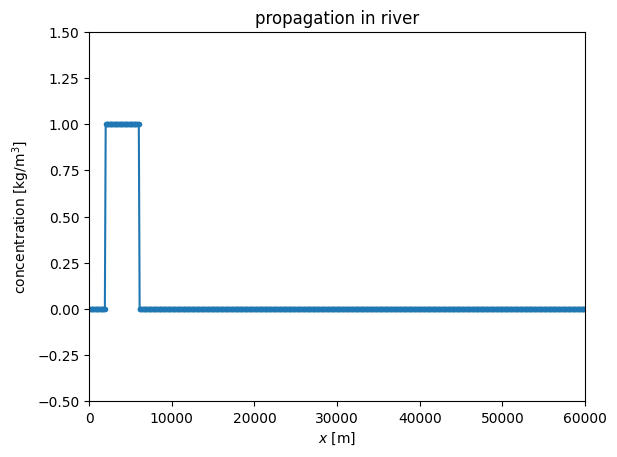

In [5]:
plot_1D(x, c_all)

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2</b>

1. Run the cell below to see what happens to the box-shaped cloud when moving from the left to right. Explain your findings based on the theory.
2. Adapt the shape of the cloud to make it more smooth and run again (see second cell below). What do you observe?
3. Repeat the two runs again but this time with the first order upwind scheme. (See third cell below.)

</p>
</div>

In [6]:
plot_1D_all()

interactive(children=(Play(value=0, description='step', max=649), Output()), _dom_classes=('widget-interact',)…

In [7]:
square=False
x, c_all = run_simulation_1D(c0, u, L, Nx, T, Nt, central, square)
plot_1D_all()

interactive(children=(Play(value=0, description='step', max=649), Output()), _dom_classes=('widget-interact',)…

In [8]:
# re-define key variables for upwind and re-run with run_simulation_1D() and plot_1D_all()
square=True
central=False
x, c_all = run_simulation_1D(c0, u, L, Nx, T, Nt, central, square)
plot_1D_all()

interactive(children=(Play(value=0, description='step', max=649), Output()), _dom_classes=('widget-interact',)…

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>
<b>Solution 2.2</b>

1. The FTCS scheme is always unstable for hyperbolic problems, including the advection equation.
2. Also for a very smooth solution the FTCS scheme remains unstable.
3. The FTBS scheme shows a stable solution to both block-shaped and bell-shaped profiles.
   In addition, the block-shaped profile deforms in the course of the simulation and becomes smoother.
   The cause lies in the presence of numerical diffusion that is produced by FTBS.
   With respect to the bell-shaped curve, it is noticed that its maximum decrease during the simulation.
   Numerical diffusion is also responsible for this.

</p>
</div>

## Part 3: stability and numerical diffusion of FTBS

With this exercise we explore the stability of the FTBS scheme. From theory, we found its stability condition as given by:

$$
  \sigma = \frac{u \, \Delta t}{\Delta x} \leq 1
$$

In addition, the FTBS scheme produces some amount of numerical diffusion and is given by

$$
  \kappa_a = -\frac 12 \, u \left ( u\,\Delta t - \Delta x \right )
$$

This amount consists of two contributions:
- the forward Euler scheme produces some amount equal to $-u^2\,\Delta t/2$ and
- the first order upwind scheme produces some other amount, namely, $u\,\Delta x/2$.

We observe that forward Euler *decreases*(!) the total amount of numerical diffusion while the upwind scheme increases that amount.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1</b>

1. Derive above $\kappa_a$ for the FTBS scheme using the Taylor series expansion.
   (*Hint*: write the result of substituting the expansions in the FTBS scheme as an advection-diffusion equation.)
   Finally, calculate $\kappa_a$ based on your current numerical parameters.
2. Observe how the results of the upwind scheme changes with different time steps. For example, what happens when the time step is doubled?
   Compute the Courant number.
3. Follow up to previous question, how would you adapt the mesh size such that the solution becomes stable again? Compare the results with the
   ones obtained in <b>Task 2.2</b>.
   Look at the movement of the center of gravity and also at the shape. Explain your findings based on the notion of numerical diffusion.
4. What happens when the time step is halved? (Use again $\Delta x = 100$ m.) Compute again $\kappa_a$.
   Compare with the previous results. What do you observe? Explain your findings.
5. Compute the time step $\Delta t$ such that the Courant number $\sigma$ is precisely 1. Rerun the simulation. What do you observe?
   What is $\kappa_a$? Can you explain your observations?
</p>
</div>

In [9]:
# run the simulation with different time steps
T = 104000
Nt = 650
square = True
central = False
x, c_all = run_simulation_1D(c0, u, L, Nx, T, Nt, central, square)
check_variables_1D()
plot_1D_all()

Current variables values:
  c0 [---]: 1.00
  u  [m/s]: 0.50
  L  [ m ]: 60000.0
  Nx [---]:  600
  T  [ s ]: 104000.0
  Nt [---]:  650
  dx [ m ]: 1.00e+02
  dt [ s ]: 1.60e+02
Using central differences?: False
Using square init. cond.? : True
CFL: 8.00e-01


interactive(children=(Play(value=0, description='step', max=649), Output()), _dom_classes=('widget-interact',)…

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>
<b>Solution 3.1</b>

1. The idea is to rewrite the FTBS scheme as an advection-diffusion equation. First, we replace the numerical solution by the exact one
   which yields ($u>0$):

   $$
      \frac{c(x_m,t_{n+1}) - c(x_m,t_n)}{\Delta t} + u \frac{c(x_m,t_n) - c(x_{m-1},t_n)}{\Delta x} = 0
   $$

   To find the total amount of numerical diffusion that is produced by the FTBS scheme, we will use the following Taylor expansions up to
   and including second order terms:

   $$
     c(x_m,t_{n+1}) = c(x_m,t_n) + \Delta t \, c_t(x_m,t_n) + \frac 12 \,\Delta t^2\,c_{tt}(x_m,t_n)
   $$

   and

   $$
     c(x_{m-1},t_n) = c(x_m,t_n) - \Delta x \, c_x(x_m,t_n) + \frac 12 \,\Delta x^2\,c_{xx}(x_m,t_n)
   $$

   Substitution yields

   $$
     \frac{\partial c}{\partial t}(x_m,t_n) + \frac 12 \,\Delta t\,\frac{\partial^2 c}{\partial t^2}(x_m,t_n) +
     u\,\frac{\partial c}{\partial x}(x_m,t_n) - \frac 12 u\,\Delta x\,\frac{\partial^2 c}{\partial t^2}(x_m,t_n) = 0
   $$

   We now use the classical wave equation to find an expression for the second derivative with respect to time as function
   of the second derivative with respect to space. This equation is given by
   (see the MUDE book: the wave equation and the advection equation are mathematically equivalent)

   $$
    \frac{\partial^2 c}{\partial t^2} - u^2\,\frac{\partial^2 c}{\partial x^2} = 0
   $$

   Plugging in the second term of the PDE gives the following equation at point $(x_m,t_n)$:

   $$
     \frac{\partial c}{\partial t} + u \frac{\partial c}{\partial x} - \kappa_a \frac{\partial^2 c}{\partial x^2} = 0
   $$

   with

   $$
     \kappa_a = -\frac 12 \, u \left ( u\,\Delta t - \Delta x \right )
   $$

   Our numerical parameters here are $\Delta t = 160$ s, $\Delta x = 100$ m and $u = 0.5$ m/s. Thus, $\kappa_a = 5$ m$^2$/s.
2. If the time step is doubled, then also the Courant number doubles. In this case, $\sigma  = 1.6 > 1$ and hence unstable.
3. The mesh size should be doubled as well so that the Courant number remains unchanged. Hence, $\Delta x = 200$ m.
   The amount of numerical diffusion $\kappa_a$ becomes twice larger, so that the numerical solution will be more spread compared to
   the previous results.
4. The Courant number is now 0.4. Although we would expect more accurate results, the opposite is the case, namely, there is more
   numerical diffusion (either the width of the profile becomes wider and/or its maximum becomes smaller).
   This is due to the *anti-diffusion* effect of the forward Euler scheme: this becomes smaller as the time step is decreased.
   This implies that $\kappa_a$ becomes larger which explains the observation.
   So, with $\Delta t = 80$ s, $\Delta x = 100$ m and $u = 0.5$ m/s, we now have $\kappa_a = 15$ m$^2$/s, three times larger than
   the original run.
5. The modified time step is $\Delta t = \Delta x / u = 100/0.5 = 200$ s, or <code>Nt</code> = 104000/200 = 520. In addition, $\kappa_a = 0$ m$^2$/s.

   A nice property of the FTBS scheme is that it has a point-to-point transfer.
   This means that this scheme provides an exact result as soon as $\sigma = 1$. This is seen as follows.

   $$
    \frac{c^{n+1}_m-c^n_m}{\Delta t} + u \frac{c^n_{m}-c^n_{m-1}}{\Delta x} = 0 \quad \Rightarrow \quad  c^{n+1}_m = c^n_m -
    \sigma \left ( c^n_{m} - c^n_{m-1} \right )
   $$

   So, if $\sigma = 1$, then

   $$
     c^{n+1}_m = c^n_{m-1}
   $$

   which indicates transfer of $c(x,t)$ from point $(x_{m-1},t_n)$ to point $(x_m,t_{n+1})$ along the characteristic.
   Hence, we will notice a travelling cloud without any deformation. This is also confirmed by the fact that there is no
   diffusion present (neither physically nor numerically).

   Basically, a numerical scheme that has a point-to-point transfer becomes rather accurate when the Courant number is close to 1 while a
   scheme that does not share this property is rather inaccurate when $\sigma \approx 1$.
</p>
</div>

> By Marcel Zijlema, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).